In [37]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

# Data preprocessing

In [38]:
import tensorflow as tf
import os

DATASET_DIR = 'aug_dataset' 

# Đường dẫn tới các thư mục lớp
class_names = ['High squamous intra-epithelial lesion', 'Low squamous intra-epithelial lesion', 'Negative for Intraepithelial malignancy', 'Squamous cell carcinoma']
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training",    
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  
    subset="validation",   
    seed=123,              
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)


Found 11544 files belonging to 4 classes.
Using 9236 files for training.
Found 11544 files belonging to 4 classes.
Using 2308 files for validation.


In [39]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(max(1, val_batches // 5))
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

In [40]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 30
Number of test batches: 7


# Configure the dataset for performance

In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Rescale pixel values

In [42]:
# preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [43]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # [-1, 1] or [0, 1]

# Create the base model from the pre-trained convnets

In [44]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [45]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


# Feature extraction

## Freeze the convolutional base

In [46]:
base_model.trainable = False

In [47]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_10        │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_10[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_11        │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_11[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

## Add a classification head

In [48]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [49]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 4)


In [50]:
inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [51]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [52]:
len(model.trainable_variables)

2

## Compile the model

In [53]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),  # Hoặc SparseCategoricalCrossentropy
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])  # Hoặc SparseCategoricalAccuracy

## Train the model

In [54]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

2024-11-16 09:37:52.999740: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 636ms/step - accuracy: 0.1032 - loss: 1.7131


In [55]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.71
initial accuracy: 0.10


In [56]:
model_checkpoint = ModelCheckpoint(
    filepath='efficientNet_B0_Aug.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)


In [57]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_duration = end_time - self.start_time
        self.epoch_times.append(epoch_duration)
        print(f"Epoch {epoch + 1} duration: {epoch_duration:.2f} seconds")

In [58]:
time_callback = TimeHistory()

In [59]:
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[model_checkpoint, time_callback]
)

Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.3728 - loss: 1.3116

2024-11-16 09:39:54.207839: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 1: val_loss improved from inf to 0.77685, saving model to efficientNet_B0_Aug.keras
Epoch 1 duration: 120.98 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 121s 799ms/step - accuracy: 0.3739 - loss: 1.3099 - val_accuracy: 0.6559 - val_loss: 0.7768
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.6987 - loss: 0.7429

2024-11-16 09:41:49.456508: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 2: val_loss improved from 0.77685 to 0.60150, saving model to efficientNet_B0_Aug.keras
Epoch 2 duration: 114.93 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 115s 792ms/step - accuracy: 0.6990 - loss: 0.7425 - val_accuracy: 0.7817 - val_loss: 0.6015
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.7903 - loss: 0.5915

2024-11-16 09:43:43.521355: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 3: val_loss improved from 0.60150 to 0.49509, saving model to efficientNet_B0_Aug.keras
Epoch 3 duration: 114.29 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 114s 788ms/step - accuracy: 0.7904 - loss: 0.5913 - val_accuracy: 0.8355 - val_loss: 0.4951
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.8461 - loss: 0.4920

2024-11-16 09:45:38.923730: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 4: val_loss improved from 0.49509 to 0.43025, saving model to efficientNet_B0_Aug.keras
Epoch 4 duration: 115.28 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 115s 794ms/step - accuracy: 0.8461 - loss: 0.4919 - val_accuracy: 0.8710 - val_loss: 0.4303
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.8598 - loss: 0.4370

2024-11-16 09:47:33.130410: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 5: val_loss improved from 0.43025 to 0.38108, saving model to efficientNet_B0_Aug.keras
Epoch 5 duration: 113.94 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 114s 783ms/step - accuracy: 0.8598 - loss: 0.4368 - val_accuracy: 0.8919 - val_loss: 0.3811
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.8795 - loss: 0.3924

2024-11-16 09:49:27.596550: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 6: val_loss improved from 0.38108 to 0.34016, saving model to efficientNet_B0_Aug.keras
Epoch 6 duration: 114.73 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 115s 791ms/step - accuracy: 0.8795 - loss: 0.3923 - val_accuracy: 0.9048 - val_loss: 0.3402
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.8941 - loss: 0.3534

2024-11-16 09:51:22.696775: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 7: val_loss improved from 0.34016 to 0.30985, saving model to efficientNet_B0_Aug.keras
Epoch 7 duration: 114.85 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 115s 792ms/step - accuracy: 0.8941 - loss: 0.3534 - val_accuracy: 0.9183 - val_loss: 0.3098
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.9020 - loss: 0.3331

2024-11-16 09:53:17.057899: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 8: val_loss improved from 0.30985 to 0.28380, saving model to efficientNet_B0_Aug.keras
Epoch 8 duration: 114.67 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 115s 791ms/step - accuracy: 0.9020 - loss: 0.3330 - val_accuracy: 0.9258 - val_loss: 0.2838
Epoch 9/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9082 - loss: 0.3019

2024-11-16 09:55:12.979587: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 9: val_loss improved from 0.28380 to 0.26883, saving model to efficientNet_B0_Aug.keras
Epoch 9 duration: 115.95 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 116s 800ms/step - accuracy: 0.9082 - loss: 0.3019 - val_accuracy: 0.9296 - val_loss: 0.2688
Epoch 10/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9153 - loss: 0.2874

2024-11-16 09:57:07.487340: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 10: val_loss improved from 0.26883 to 0.25628, saving model to efficientNet_B0_Aug.keras
Epoch 10 duration: 114.16 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 114s 787ms/step - accuracy: 0.9153 - loss: 0.2873 - val_accuracy: 0.9296 - val_loss: 0.2563
Epoch 11/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.9225 - loss: 0.2694

2024-11-16 09:59:01.513323: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 11: val_loss improved from 0.25628 to 0.23262, saving model to efficientNet_B0_Aug.keras
Epoch 11 duration: 114.40 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 114s 789ms/step - accuracy: 0.9226 - loss: 0.2694 - val_accuracy: 0.9382 - val_loss: 0.2326
Epoch 12/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.9295 - loss: 0.2598

2024-11-16 10:00:58.082356: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 12: val_loss improved from 0.23262 to 0.21938, saving model to efficientNet_B0_Aug.keras
Epoch 12 duration: 116.67 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 117s 805ms/step - accuracy: 0.9295 - loss: 0.2598 - val_accuracy: 0.9441 - val_loss: 0.2194
Epoch 13/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9271 - loss: 0.2445

2024-11-16 10:02:54.272323: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 13: val_loss improved from 0.21938 to 0.21636, saving model to efficientNet_B0_Aug.keras
Epoch 13 duration: 115.97 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 116s 799ms/step - accuracy: 0.9271 - loss: 0.2444 - val_accuracy: 0.9430 - val_loss: 0.2164
Epoch 14/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.9281 - loss: 0.2371

2024-11-16 10:04:49.111000: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 14: val_loss improved from 0.21636 to 0.20362, saving model to efficientNet_B0_Aug.keras
Epoch 14 duration: 115.07 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 115s 791ms/step - accuracy: 0.9281 - loss: 0.2371 - val_accuracy: 0.9473 - val_loss: 0.2036
Epoch 15/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.9263 - loss: 0.2270

2024-11-16 10:06:43.996624: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 15: val_loss improved from 0.20362 to 0.19031, saving model to efficientNet_B0_Aug.keras
Epoch 15 duration: 114.41 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 114s 789ms/step - accuracy: 0.9264 - loss: 0.2269 - val_accuracy: 0.9505 - val_loss: 0.1903
Epoch 16/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9373 - loss: 0.2153

2024-11-16 10:08:37.629841: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 16: val_loss improved from 0.19031 to 0.18565, saving model to efficientNet_B0_Aug.keras
Epoch 16 duration: 113.85 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 114s 783ms/step - accuracy: 0.9373 - loss: 0.2153 - val_accuracy: 0.9516 - val_loss: 0.1857
Epoch 17/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.9429 - loss: 0.2084

2024-11-16 10:10:33.893247: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 17: val_loss improved from 0.18565 to 0.18231, saving model to efficientNet_B0_Aug.keras
Epoch 17 duration: 116.20 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 116s 802ms/step - accuracy: 0.9429 - loss: 0.2083 - val_accuracy: 0.9532 - val_loss: 0.1823
Epoch 18/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9433 - loss: 0.1986

2024-11-16 10:12:28.478259: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 18: val_loss improved from 0.18231 to 0.17225, saving model to efficientNet_B0_Aug.keras
Epoch 18 duration: 114.64 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 115s 788ms/step - accuracy: 0.9433 - loss: 0.1985 - val_accuracy: 0.9602 - val_loss: 0.1723
Epoch 19/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.9496 - loss: 0.1915

2024-11-16 10:14:23.575584: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 19: val_loss improved from 0.17225 to 0.16217, saving model to efficientNet_B0_Aug.keras
Epoch 19 duration: 115.05 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 115s 792ms/step - accuracy: 0.9496 - loss: 0.1915 - val_accuracy: 0.9618 - val_loss: 0.1622
Epoch 20/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.9434 - loss: 0.1885

2024-11-16 10:16:18.585823: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 20: val_loss improved from 0.16217 to 0.15944, saving model to efficientNet_B0_Aug.keras
Epoch 20 duration: 114.91 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 115s 791ms/step - accuracy: 0.9434 - loss: 0.1884 - val_accuracy: 0.9613 - val_loss: 0.1594


In [60]:
actual_initial_epochs = len(history.epoch) 

In [61]:
actual_initial_epochs

20

## Learning curves

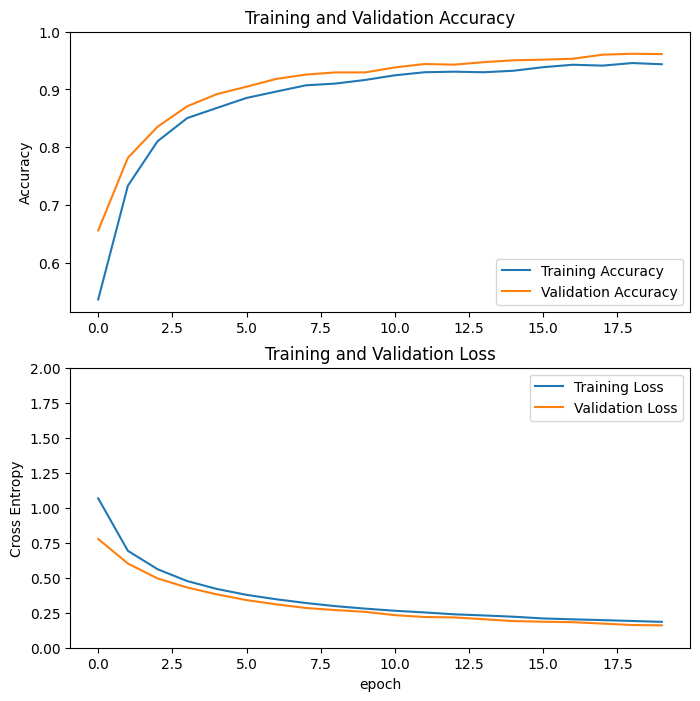

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Time training

### Sum all of epochs


In [63]:
total_time = sum(time_callback.epoch_times)
print(f"Total time for training: {total_time:.2f} seconds")

Total time for training: 2304.95 seconds


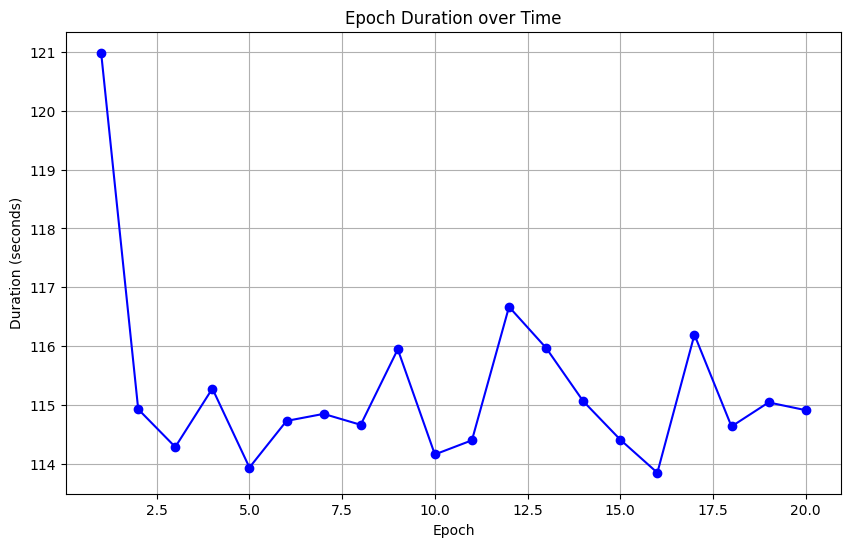

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(time_callback.epoch_times) + 1), time_callback.epoch_times, marker='o', color='b')
plt.title('Epoch Duration over Time')
plt.xlabel('Epoch')
plt.ylabel('Duration (seconds)')
plt.grid(True)
plt.show()

## Evaluate and predict

Model loaded successfully from checkpoint.


2024-11-16 10:16:40.311042: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 636ms/step - accuracy: 0.9851 - loss: 0.1331
Test loss: 0.13546684384346008
Test accuracy: 0.9754464030265808
Predicted classes:
 [0 2 3 2 2 2 2 0 2 1 0 2 1 2 2 0 2 1 2 0 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 1
 0 2 2 2 0 2 2 3 0 1 2 2 2 2 2 2 2 2 2 2 2 2 3 0 0 2 2]
True classes:
 [0 2 3 2 2 2 2 0 2 1 0 2 1 2 2 0 2 1 2 3 2 0 2 2 2 0 2 2 2 2 2 0 2 2 2 2 1
 0 2 2 2 0 2 2 3 0 1 2 2 2 2 2 2 2 2 2 2 2 2 3 0 0 2 2]


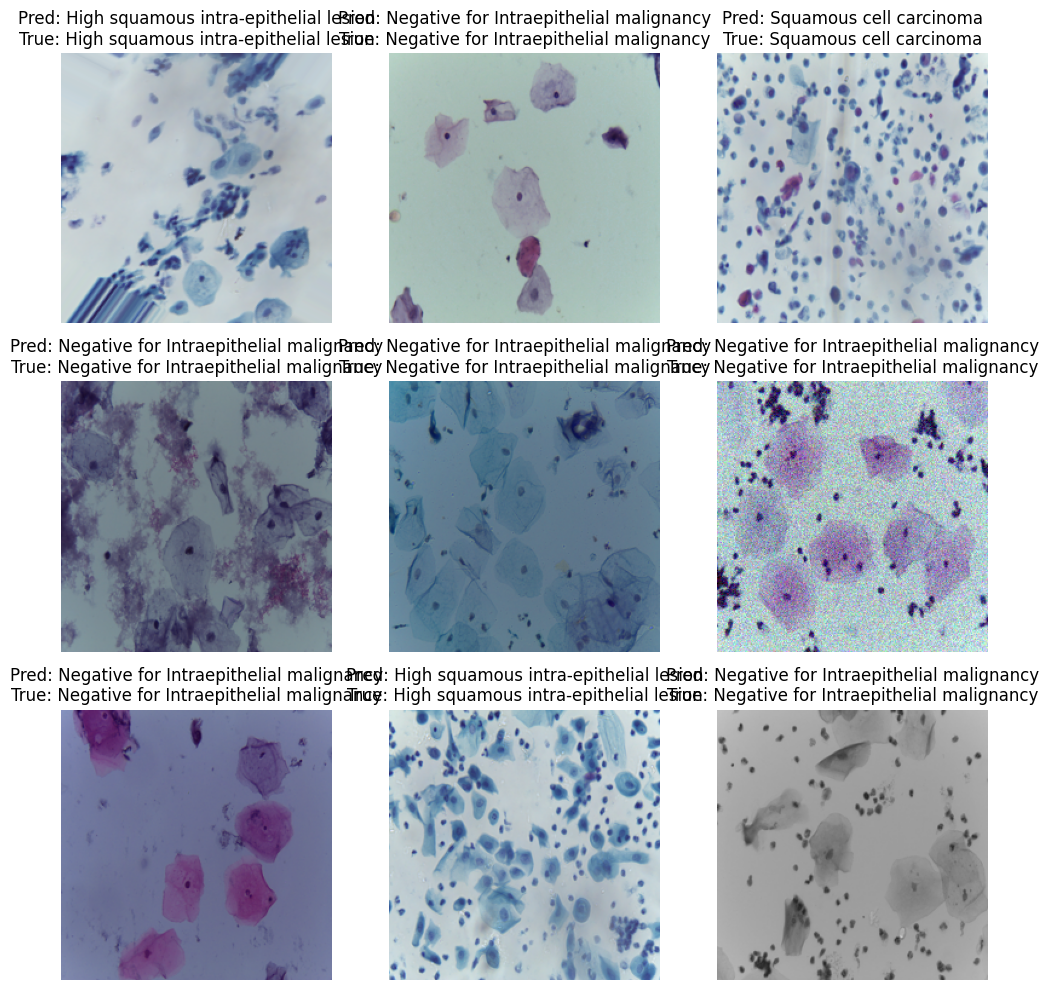

In [65]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Đường dẫn checkpoint
checkpoint_path = 'efficientNet_B0_Aug.keras'

# Load mô hình từ checkpoint
model = tf.keras.models.load_model(checkpoint_path)
print("Model loaded successfully from checkpoint.")

# Evaluate trên tập test
loss, accuracy = model.evaluate(test_dataset)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Lấy một batch ảnh từ tập test
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Dự đoán trên batch này
predictions = model.predict_on_batch(image_batch)

# Lấy chỉ số lớp dự đoán cao nhất
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(label_batch, axis=1)

# In ra kết quả dự đoán và nhãn thật
print('Predicted classes:\n', predicted_classes)
print('True classes:\n', true_classes)

# Hiển thị hình ảnh với dự đoán
plt.figure(figsize=(10, 10))
for i in range(9):  # Hiển thị 9 ảnh đầu tiên
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[true_classes[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
